In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
import ast # For literal_eval

# Load the dataset
df = pd.read_csv('complete_dataset.csv')


df.drop_duplicates()

# Initial data inspection
print("\nInitial DataFrame Info:")
df.info()
df.describe()
print("\nFirst 5 rows of the dataset:")
print(df.head())

--- 6.1. Data Loading and Preprocessing ---

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7575 entries, 0 to 7574
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              7575 non-null   int64  
 1   name            7575 non-null   object 
 2   year_published  7575 non-null   int64  
 3   min_players     7575 non-null   int64  
 4   max_players     7575 non-null   int64  
 5   playing_time    7575 non-null   int64  
 6   min_play_time   7575 non-null   int64  
 7   max_play_time   7575 non-null   int64  
 8   min_age         7575 non-null   int64  
 9   description     7575 non-null   object 
 10  categories      7575 non-null   object 
 11  mechanisms      7575 non-null   object 
 12  designers       7575 non-null   object 
 13  artists         7575 non-null   object 
 14  publishers      7575 non-null   object 
 15  users_rated     7575 non-null   int64  
 16  average_r

In [2]:
# For other numerical columns, fill NaNs with the mean or median if appropriate.
# For simplicity, we'll fill with the mean for relevant numerical columns.
numerical_cols_to_impute = ['average_rating', 'bayes_average', 'users_rated', 
                            'num_comments', 'num_weights', 'average_weight',
                            'min_players', 'max_players', 'playing_time', 
                            'min_play_time', 'max_play_time', 'min_age']
for col in numerical_cols_to_impute:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)
        print(f"Filled NaN in '{col}' with mean.")

# Parsing 'category_ranks' column
# This column is a string representation of a dictionary, e.g., "{'strategygames': 1}"
def parse_category_ranks(rank_str):
    try:
        # Safely evaluate the string as a Python literal (dictionary)
        return ast.literal_eval(rank_str)
    except (ValueError, SyntaxError):
        return {} # Return empty dict for unparseable strings

df['parsed_category_ranks'] = df['category_ranks'].apply(parse_category_ranks)

# Extract the best category rank (lowest number) if available
df['best_category_rank'] = df['parsed_category_ranks'].apply(
    lambda x: min(x.values()) if x else np.nan
)
print("\nSample of parsed_category_ranks and best_category_rank:")
print(df[['category_ranks', 'parsed_category_ranks', 'best_category_rank']].head(11))

# Only best needed after extraction
df.drop(columns=['parsed_category_ranks', 'category_ranks'], axis= 1, inplace=True)

# Convert 'categories' and 'mechanisms' from string to list of strings for better interperation later
# They are often comma-separated strings that might have leading/trailing spaces.
def clean_list_string(text):
    if isinstance(text, str):
        return [item.strip() for item in text.split(',') if item.strip()]
    return

df['categories_list'] = df['categories'].apply(clean_list_string)
df['mechanisms_list'] = df['mechanisms'].apply(clean_list_string)

print("\nSample of cleaned categories_list and mechanisms_list:")
print(df[['categories', 'categories_list', 'mechanisms', 'mechanisms_list']].head(11))

df.drop(columns=['categories', 'mechanisms'], axis= 1, inplace=True)

print('Dateframe columns after elimination \n' ,df.columns)


Sample of parsed_category_ranks and best_category_rank:
                        category_ranks               parsed_category_ranks  \
0                {'strategygames': 68}               {'strategygames': 68}   
1                     {'thematic': 50}                    {'thematic': 50}   
2                    {'abstracts': 18}                   {'abstracts': 18}   
3                  {'familygames': 88}                 {'familygames': 88}   
4                    {'abstracts': 12}                   {'abstracts': 12}   
5                   {'partygames': 28}                  {'partygames': 28}   
6               {'strategygames': 468}              {'strategygames': 468}   
7               {'strategygames': 480}              {'strategygames': 480}   
8                 {'familygames': 258}                {'familygames': 258}   
9                    {'abstracts': 57}                   {'abstracts': 57}   
10  {'wargames': 112, 'thematic': 169}  {'wargames': 112, 'thematic': 169}   

    be

In [3]:
# Creating a new column based on ratio of people who commented on game and who rated on a game
df["popularity_raw"] = df["users_rated"] / df["num_comments"]

df["popularity_raw"] = df["popularity_raw"].fillna(0)

scaler = MinMaxScaler()
df["popularity"] = scaler.fit_transform(df[["popularity_raw"]])

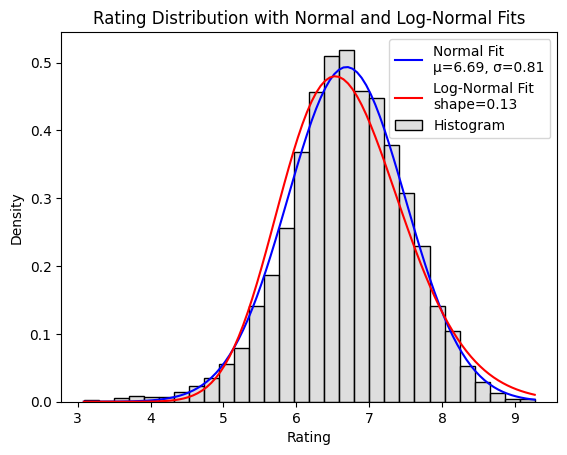

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm, lognorm

ratings = df["average_rating"].dropna()

# Histogram
sns.histplot(ratings, bins=30, kde=False, stat="density", label="Histogram", color="lightgray")

# Normal distribution fit
mu, sigma = norm.fit(ratings)
x = np.linspace(ratings.min(), ratings.max(), 100)
pdf_normal = norm.pdf(x, mu, sigma)
plt.plot(x, pdf_normal, 'b-', label=f"Normal Fit\nμ={mu:.2f}, σ={sigma:.2f}")

# Log-normal distribution fit
shape, loc, scale = lognorm.fit(ratings, floc=0)  # Fix location to 0 for better stability
pdf_lognorm = lognorm.pdf(x, shape, loc=loc, scale=scale)
plt.plot(x, pdf_lognorm, 'r-', label=f"Log-Normal Fit\nshape={shape:.2f}")

plt.title("Rating Distribution with Normal and Log-Normal Fits")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()
plt.show()

In [5]:
prior_mean = df["average_rating"].mean()
print('Mean number of rates ', df["users_rated"].mean())
prior_weight = 2000

df["adjusted_rating"] = (
    (df["average_rating"] * df["users_rated"] + prior_mean * prior_weight) /
    (df["users_rated"] + prior_weight)
)

prior_mean = df["average_weight"].mean()
print('Mean number of rates ', df["num_weights"].mean())
prior_weight = 100

df["adjusted_weight"] = (
    (df["average_weight"] * df["num_weights"] + prior_mean * prior_weight) /
    (df["num_weights"] + prior_weight)
)

print(df.head())

df.drop(columns=['average_rating', 'average_weight'], axis=1, inplace=True)
print('Dataset head after normalized',df.head(10))



Mean number of rates  2130.0277227722772
Mean number of rates  105.46349834983498
     id                                               name  year_published  \
0  2651                                         Power Grid            2004   
1  2511  Sherlock Holmes Consulting Detective: The Tham...            1981   
2  2655                                               Hive            2001   
3  2653                     Survive: Escape from Atlantis!            1982   
4  2346                                              DVONN            2001   

   min_players  max_players  playing_time  min_play_time  max_play_time  \
0            2            6           120            120            120   
1            1            8           120             60            120   
2            2            2            20             20             20   
3            2            4            60             45             60   
4            2            2            30             30             30   

In [6]:
# playing time and max_playing_time is equal thus drop
df.drop(columns=['playing_time'])
df['average_playing_time'] = (df['min_play_time'] + df['max_play_time']) / 2
df['average_players'] = (df['min_players'] + df['max_players']) / 2
df['player_flexibility'] = df['max_players'] - df['min_players']
df['time_per_player'] = df['average_playing_time'] / df['average_players']


Pearson Correlation Matrix:
                      adjusted_rating  year_published  bayes_average  \
adjusted_rating              1.000000        0.104670       0.850186   
year_published               0.104670        1.000000       0.091271   
bayes_average                0.850186        0.091271       1.000000   
bgg_rank                    -0.529722       -0.138022      -0.689811   
adjusted_weight              0.553415        0.042525       0.342737   
average_players             -0.053029        0.004297       0.016271   
average_playing_time         0.013666       -0.003186      -0.023259   
time_per_player              0.034605       -0.002548      -0.060503   
min_age                      0.216325        0.057661       0.211482   

                      bgg_rank  adjusted_weight  average_players  \
adjusted_rating      -0.529722         0.553415        -0.053029   
year_published       -0.138022         0.042525         0.004297   
bayes_average        -0.689811         0.34273

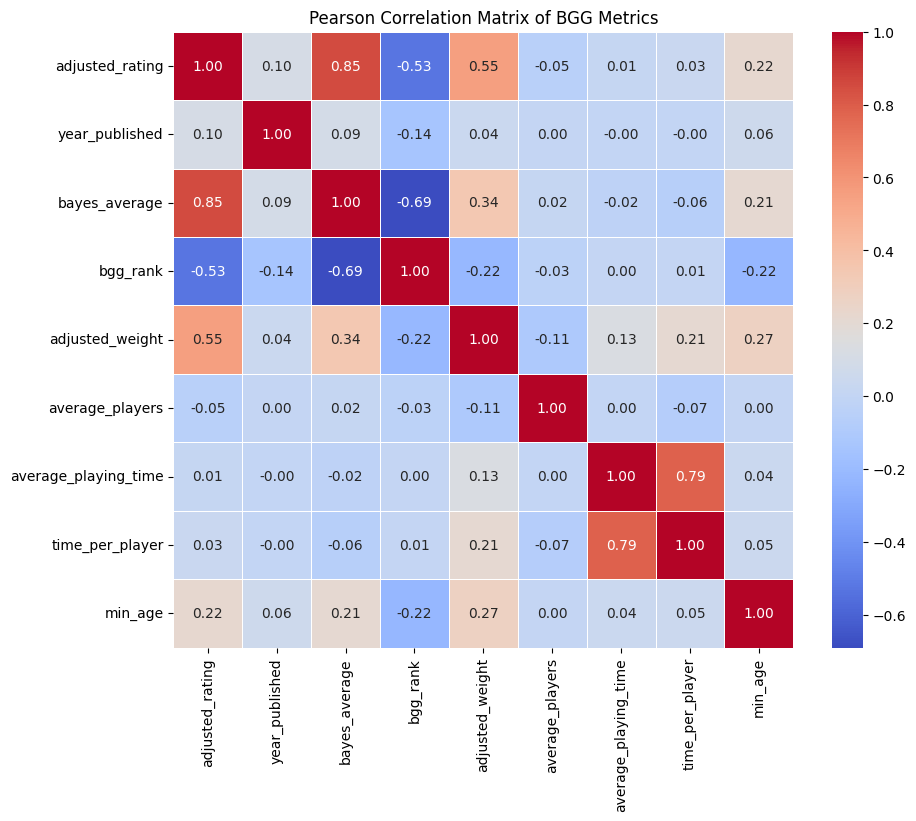

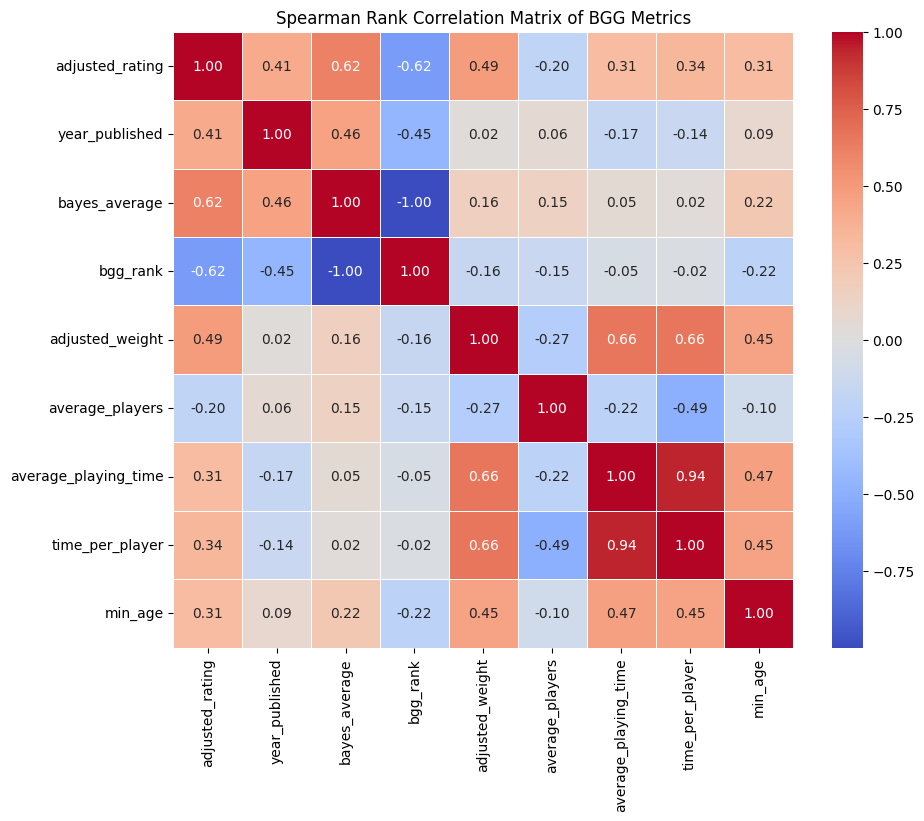

In [7]:
# Select relevant numerical columns for correlation analysis
correlation_cols = ['adjusted_rating', 'year_published', 'bayes_average', 'bgg_rank', 
                     'adjusted_weight', 'average_players', 'average_playing_time', 'time_per_player', 'min_age']

# Ensure all columns are numeric
for col in correlation_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any NaN in selected columns for clean correlation calculation
df_corr = df[correlation_cols].dropna()

# Calculate Pearson correlation matrix
pearson_corr = df_corr.corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(pearson_corr)

# Calculate Spearman rank correlation matrix (especially useful for bgg_rank)
spearman_corr = df_corr.corr(method='spearman')
print("\nSpearman Rank Correlation Matrix:")
print(spearman_corr)

# Visualize Pearson correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix of BGG Metrics')
plt.show()

# Visualize Spearman correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Spearman Rank Correlation Matrix of BGG Metrics')
plt.show()


Sample of one-hot encoded features (first few columns) and new counts/flags:
     id                                               name  year_published  \
0  2651                                         Power Grid            2004   
1  2511  Sherlock Holmes Consulting Detective: The Tham...            1981   
2  2655                                               Hive            2001   
3  2653                     Survive: Escape from Atlantis!            1982   
4  2346                                              DVONN            2001   

   min_players  max_players  playing_time  min_play_time  max_play_time  \
0            2            6           120            120            120   
1            1            8           120             60            120   
2            2            2            20             20             20   
3            2            4            60             45             60   
4            2            2            30             30             30   

  

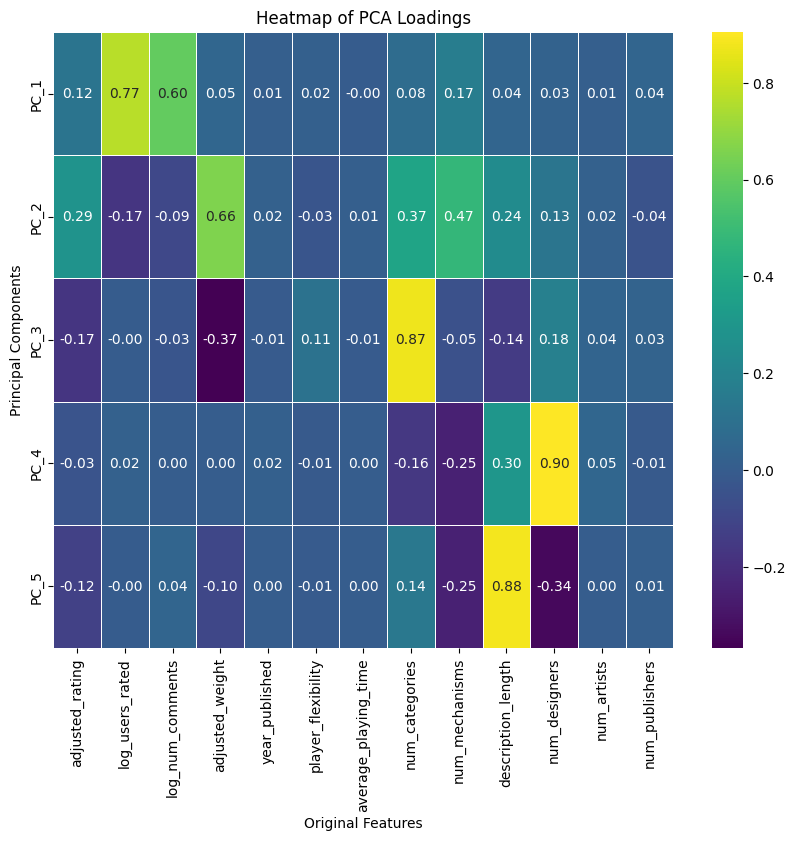

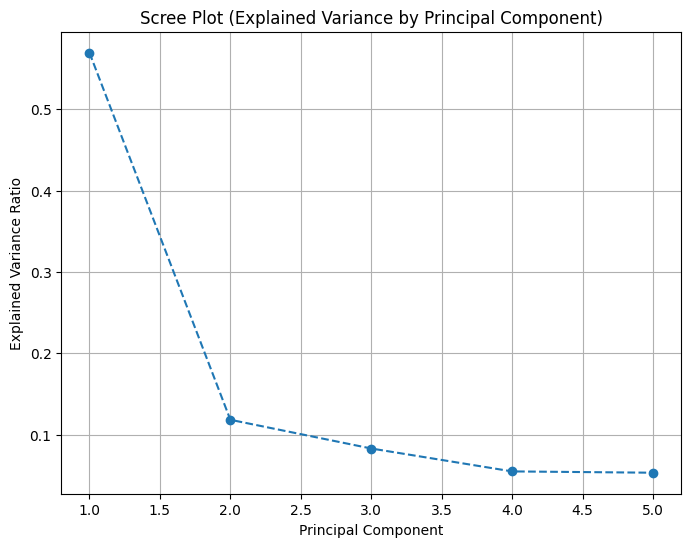

In [8]:

# Feature Creation: Categorical Feature Expansion (One-Hot Encoding)
# For 'categories' and 'mechanisms', we need to handle multi-label encoding.
# MultiLabelBinarizer is suitable for this.
mlb_categories = MultiLabelBinarizer()
categories_encoded = mlb_categories.fit_transform(df['categories_list'])
categories_df = pd.DataFrame(categories_encoded, columns=mlb_categories.classes_, index=df.index)
df_copy = df.copy()

df_copy = pd.concat([df_copy, categories_df], axis=1)

mlb_mechanisms = MultiLabelBinarizer()
mechanisms_encoded = mlb_mechanisms.fit_transform(df['mechanisms_list'])
mechanisms_df = pd.DataFrame(mechanisms_encoded, columns=mlb_mechanisms.classes_, index=df.index)
df_copy = pd.concat([df_copy, mechanisms_df], axis=1)

# Add num_categories and num_mechanisms
df_copy['num_categories'] = df_copy['categories_list'].apply(len)
df_copy['num_mechanisms'] = df_copy['mechanisms_list'].apply(len)

print("\nSample of one-hot encoded features (first few columns) and new counts/flags:")
print(df_copy.head())

# Feature Creation: Textual Feature Extraction
df_copy['description_length'] = df_copy['description'].fillna('').apply(len) # Fill NaN descriptions with empty string
df_copy['num_designers'] = df_copy['designers'].apply(lambda x: len(clean_list_string(x)))
df_copy['num_artists'] = df_copy['artists'].apply(lambda x: len(clean_list_string(x)))
df_copy['num_publishers'] = df_copy['publishers'].apply(lambda x: len(clean_list_string(x)))

print("\nSample of textual features:")
print(df_copy[['name', 'description_length', 'num_designers', 'num_artists', 'num_publishers']].head())

# --- Dimensionality Reduction ---

# PCA on a subset of numerical features
# Select a set of numerical features (excluding target and highly correlated ones like bgg_rank)
df_copy["log_num_comments"] = np.log1p(df_copy["num_comments"])
df_copy["log_num_weights"] = np.log1p(df_copy["num_weights"])
df_copy["log_users_rated"] = np.log1p(df_copy["users_rated"])

pca_features = ['adjusted_rating', 'log_users_rated', 'log_num_comments', 'adjusted_weight',
                'year_published', 'player_flexibility', 'average_playing_time', 
                'num_categories', 'num_mechanisms', 'description_length',
                'num_designers', 'num_artists', 'num_publishers']

# Ensure all PCA features are numeric and handle any remaining NaNs
for col in pca_features:
    df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce').fillna(df_copy[col].mean()) # Impute any new NaNs

# Scale features before PCA
scaler_pca = MinMaxScaler()
df_pca_scaled = scaler_pca.fit_transform(df_copy[pca_features])

# Apply PCA
pca = PCA(n_components=5) # Example: reduce to 5 principal components
principal_components = pca.fit_transform(df_pca_scaled)
df_principal_components = pd.DataFrame(data=principal_components, 
                                       columns=[f'PC_{i+1}' for i in range(pca.n_components)],
                                       index=df_copy.index)

print(f"\nExplained variance ratio by principal components: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")
print("\nSample of Principal Components:")
print(df_principal_components.head())

pca_loadings = pd.DataFrame(pca.components_, columns=pca_features, index=[f'PC_{i+1}' for i in range(pca.n_components)])

# Plot heatmap of PCA loadings
plt.figure(figsize=(10, 8))
sns.heatmap(pca_loadings, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of PCA Loadings')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

# Plot scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot (Explained Variance by Principal Component)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


In [9]:

# Feature Selection (e.g., using SelectKBest with f_regression)
# Target variable for feature selection (e.g., bayes_average)
X = df_copy[pca_features] # Using the same numerical features as PCA for consistency
y = df_copy['bayes_average']

# Select top K features based on F-regression score
k_best_selector = SelectKBest(score_func=f_regression, k=10) # Select top 10 features
fit = k_best_selector.fit(X, y)

# Get selected features and their scores
df_scores = pd.DataFrame({'Feature': X.columns, 'Score': fit.scores_})
df_scores_sorted = df_scores.sort_values(by='Score', ascending=False)

print("\nTop 10 features selected by F-regression (numerical features):")
print(df_scores_sorted.head(10))

# Example: Feature selection on one-hot encoded categorical features
# Combine all one-hot encoded category and mechanism columns
ohe_features = list(categories_df.columns) + list(mechanisms_df.columns)
X_ohe = df_copy[ohe_features]

# Ensure all columns are numeric (they should be 0/1 from MultiLabelBinarizer)
# and handle any potential NaNs (though unlikely with MLB)
X_ohe = X_ohe.fillna(0)

k_best_ohe_selector = SelectKBest(score_func=f_regression, k=10)
fit_ohe = k_best_ohe_selector.fit(X_ohe, y) # Using bayes_average as target

df_ohe_scores = pd.DataFrame({'Feature': X_ohe.columns, 'Score': fit_ohe.scores_})
df_ohe_scores_sorted = df_ohe_scores.sort_values(by='Score', ascending=False)

print("\nTop 10 features selected by F-regression (one-hot encoded categories/mechanisms):")
print(df_ohe_scores_sorted.head(10))


Top 10 features selected by F-regression (numerical features):
               Feature         Score
0      adjusted_rating  19742.009161
1      log_users_rated  15140.526960
2     log_num_comments  12620.924449
8       num_mechanisms   2655.116393
3      adjusted_weight   1007.727903
12      num_publishers    662.949417
7       num_categories    151.013630
9   description_length    125.658260
4       year_published     63.683478
11         num_artists     48.871443

Top 10 features selected by F-regression (one-hot encoded categories/mechanisms):
                    Feature        Score
145        End Game Bonuses  1057.882964
81                  Wargame   609.671991
244   Solo / Solitaire Game   547.675317
254                    Tags   540.948227
200           Open Drafting   539.272262
128               Contracts   493.477798
275  Variable Player Powers   450.588368
153         Hand Management   448.974745
162                  Income   431.682268
279        Worker Placement   426.79

In [10]:
print(df.columns)

Index(['id', 'name', 'year_published', 'min_players', 'max_players',
       'playing_time', 'min_play_time', 'max_play_time', 'min_age',
       'description', 'designers', 'artists', 'publishers', 'users_rated',
       'bayes_average', 'num_comments', 'num_weights', 'bgg_rank',
       'best_category_rank', 'categories_list', 'mechanisms_list',
       'popularity_raw', 'popularity', 'adjusted_rating', 'adjusted_weight',
       'average_playing_time', 'average_players', 'player_flexibility',
       'time_per_player'],
      dtype='object')



Sample of textual features:
                                                name  description_length  \
0                                         Power Grid                1450   
1  Sherlock Holmes Consulting Detective: The Tham...                1468   
2                                               Hive                 900   
3                     Survive: Escape from Atlantis!                1373   
4                                              DVONN                 840   

   num_designers  num_artists  num_publishers  
0              1            5              25  
1              3            6              20  
2              1            1              20  
3              1            5              17  
4              1            2               7  

Pearson Correlation Matrix:
                      year_published  min_players  max_players  min_play_time  \
year_published              1.000000    -0.028856     0.007037      -0.005180   
min_players                -0.02885

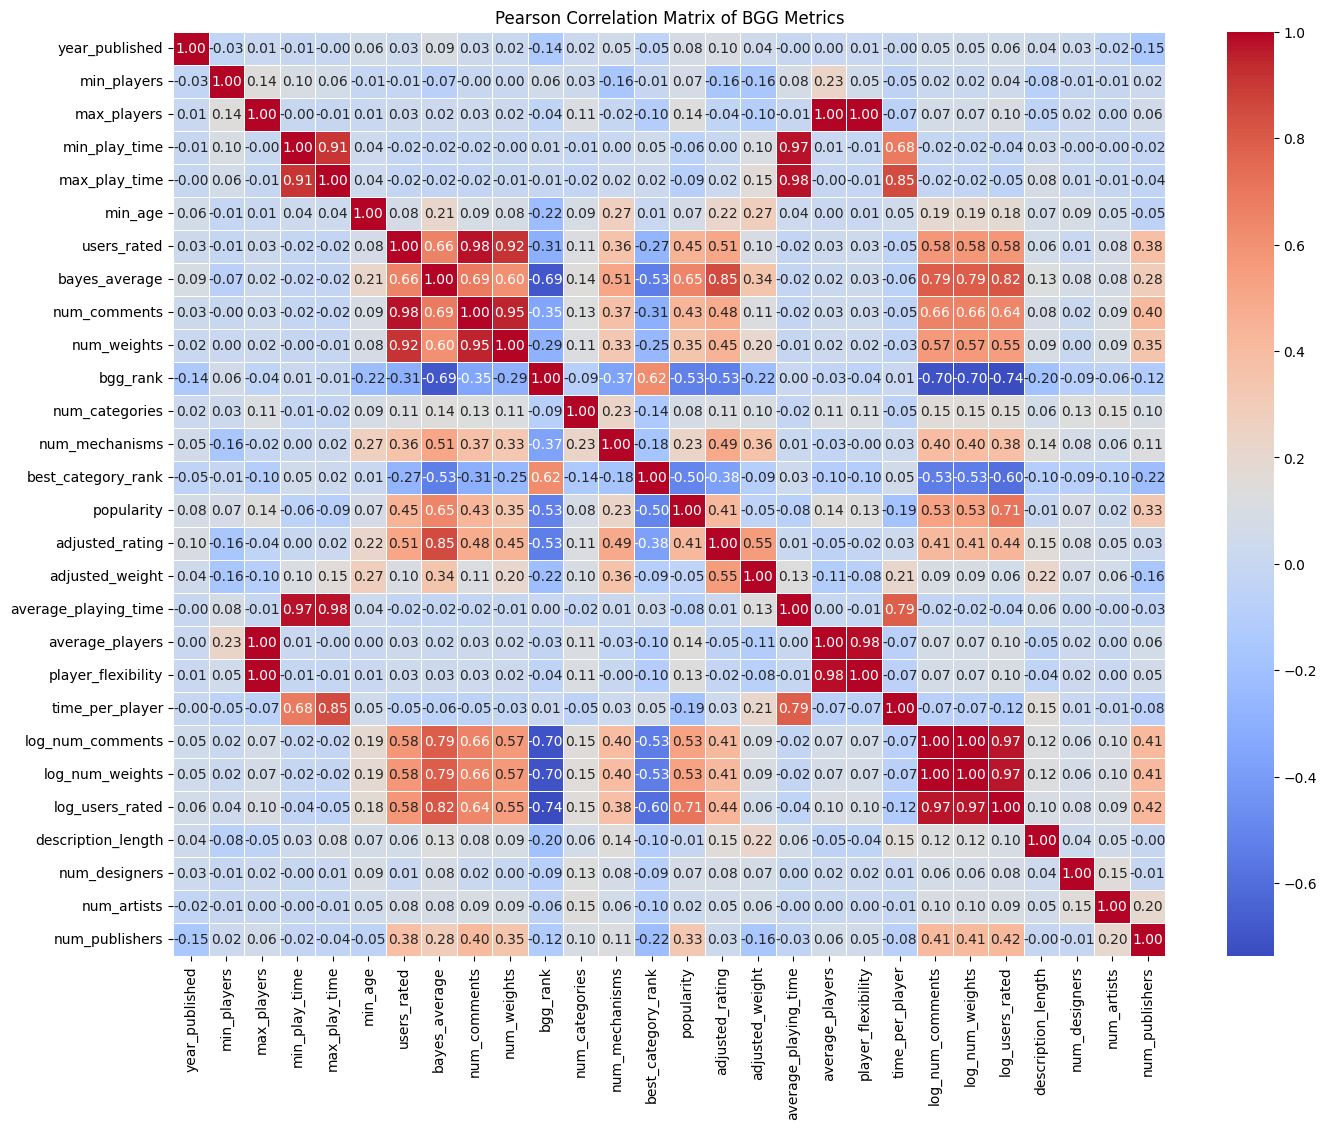

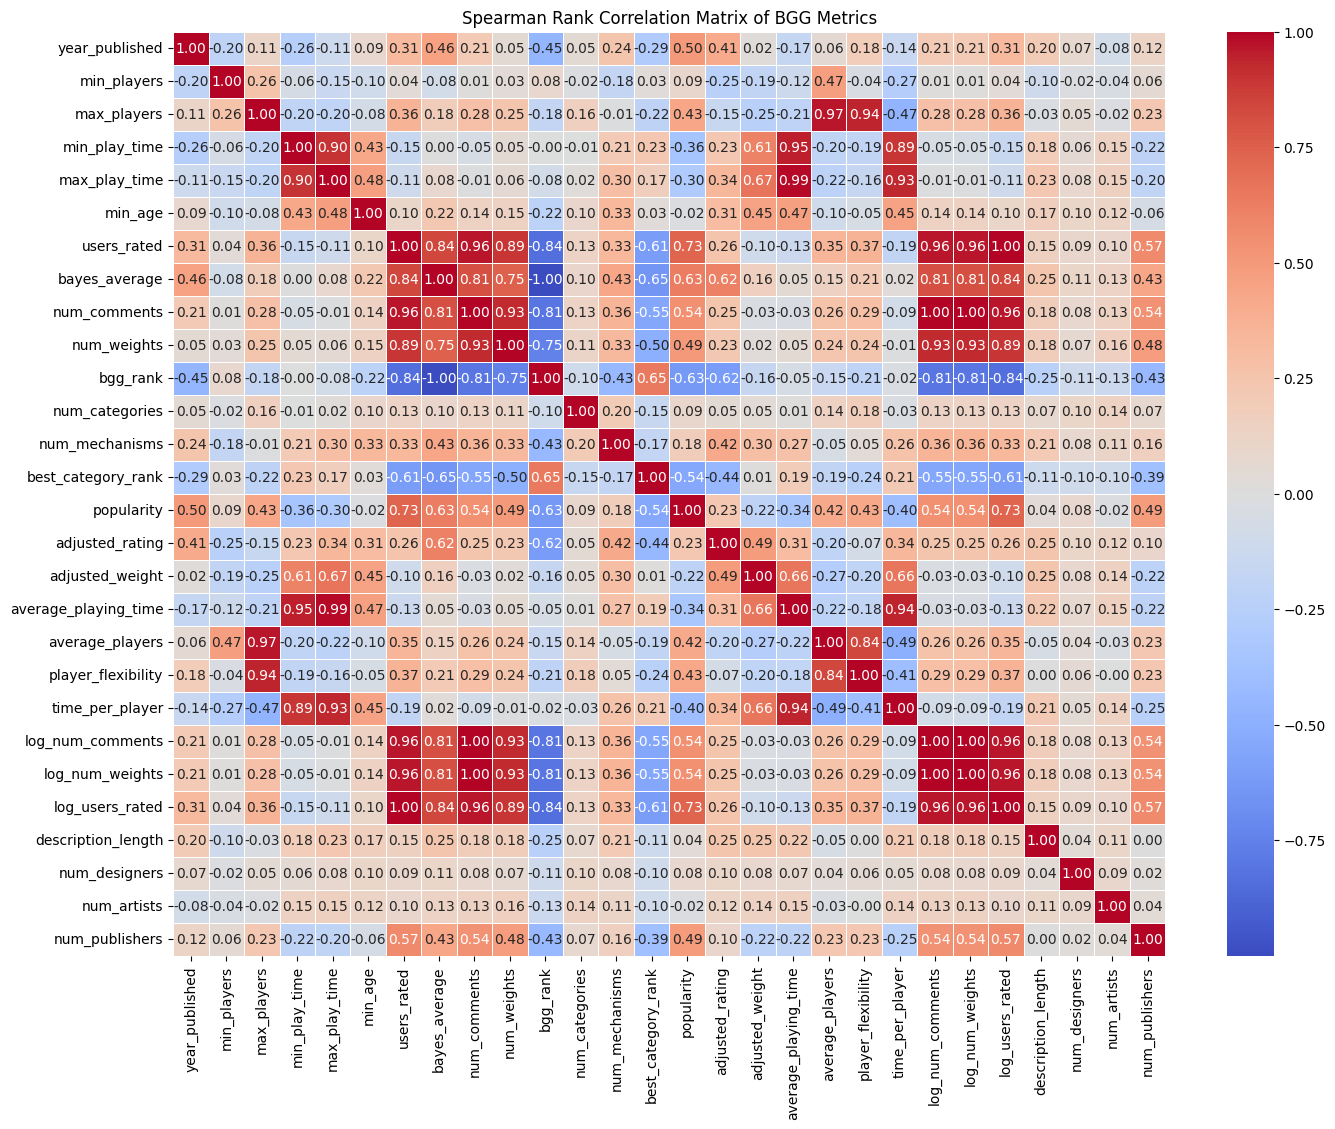

     id                                               name  year_published  \
0  2651                                         Power Grid            2004   
1  2511  Sherlock Holmes Consulting Detective: The Tham...            1981   
2  2655                                               Hive            2001   
3  2653                     Survive: Escape from Atlantis!            1982   
4  2346                                              DVONN            2001   
5  1353                                         Time's Up!            1999   
6  1513                               The Republic of Rome            1990   
7  2955                                             Mexica            2002   
8  1465                                             Wizard            1984   
9  2453                                             Blokus            2000   

   min_players  max_players  playing_time  min_play_time  max_play_time  \
0            2            6           120            120          

In [11]:

df['num_categories'] = df['categories_list'].apply(len)
df['num_mechanisms'] = df['mechanisms_list'].apply(len)


# Feature Creation: Textual Feature Extraction
df['description_length'] = df['description'].fillna('').apply(len) # Fill NaN descriptions with empty string
df['num_designers'] = df['designers'].apply(lambda x: len(clean_list_string(x)))
df['num_artists'] = df['artists'].apply(lambda x: len(clean_list_string(x)))
df['num_publishers'] = df['publishers'].apply(lambda x: len(clean_list_string(x)))

print("\nSample of textual features:")
print(df[['name', 'description_length', 'num_designers', 'num_artists', 'num_publishers']].head())

# --- Dimensionality Reduction ---

# PCA on a subset of numerical features
# Select a set of numerical features (excluding target and highly correlated ones like bgg_rank)
df["log_num_comments"] = np.log1p(df["num_comments"])
df["log_num_weights"] = np.log1p(df["num_comments"])
df["log_users_rated"] = np.log1p(df["users_rated"])

# Select relevant numerical columns for correlation analysis
correlation_cols = ['year_published', 'min_players', 'max_players', 'min_play_time', 'max_play_time', 'min_age','users_rated',
       'bayes_average', 'num_comments', 'num_weights', 'bgg_rank', 'num_categories', 'num_mechanisms',
       'best_category_rank', 'popularity', 'adjusted_rating', 'adjusted_weight',
       'average_playing_time', 'average_players', 'player_flexibility',
       'time_per_player','log_num_comments', 'log_num_weights', 'log_users_rated', 'description_length','num_designers' ,'num_artists','num_publishers']

# Ensure all columns are numeric
for col in correlation_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any NaN in selected columns for clean correlation calculation
df_corr = df[correlation_cols].dropna()

# Calculate Pearson correlation matrix
pearson_corr = df_corr.corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(pearson_corr)

# Calculate Spearman rank correlation matrix (especially useful for bgg_rank)
spearman_corr = df_corr.corr(method='spearman')
print("\nSpearman Rank Correlation Matrix:")
print(spearman_corr)

# Visualize Pearson correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix of BGG Metrics')
plt.show()

# Visualize Spearman correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Spearman Rank Correlation Matrix of BGG Metrics')
plt.show()


print(df.head(10))

In [12]:
df.drop(columns=['id', 'users_rated', 'num_comments', 'num_weights', 'categories_list', 'mechanisms_list', 'description', 'designers', 'artists', 'publishers', 'playing_time', 'min_play_time', 'max_play_time', 'bayes_average', 'player_flexibility', 'bgg_rank', 'log_num_weights', 'log_num_comments', 'log_users_rated' ,'popularity_raw',
       'num_designers', 'num_artists', 'num_publishers', 'num_mechanisms', 'num_categories', 'description_length', 'min_players', 'max_players', 'average_playing_time'], axis=1, inplace=True)

df.to_csv('preprocessed_bgg_dataset.csv')